In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

combined_data_file = "a549_combined_data.h5ad"

print(f"Loading combined dataset from {combined_data_file}...")
combined = sc.read_h5ad(combined_data_file)
print(f"Combined data shape: {combined.shape}")


Loading combined dataset from a549_combined_data.h5ad...


: 

/home/haonan.li/miniconda3/envs/scvi/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:74: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/haonan.li/miniconda3/envs/scvi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/haonan.li/miniconda3/envs/scvi/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:439: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


/tmp/ipykernel_2417905/844753386.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_raw.set_xticklabels(ax_raw.get_xticklabels(), rotation=90)
/tmp/ipykernel_2417905/844753386.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_norm.set_xticklabels(ax_norm.get_xticklabels(), rotation=90)
/tmp/ipykernel_2417905/844753386.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_raw.set_xticklabels(ax_raw.get_xticklabels(), rotation=90)
/tmp/ipykernel_2417905/844753386.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_norm.set_xticklabels(ax_norm.get_xticklabels(), rotation=90)
/tmp/ipykernel_2417905/844753386.py:101: FutureWarning: In the futur

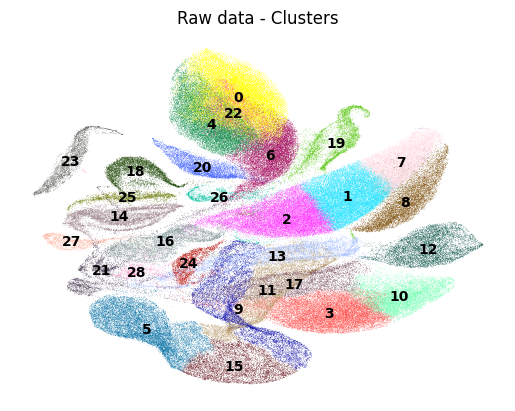

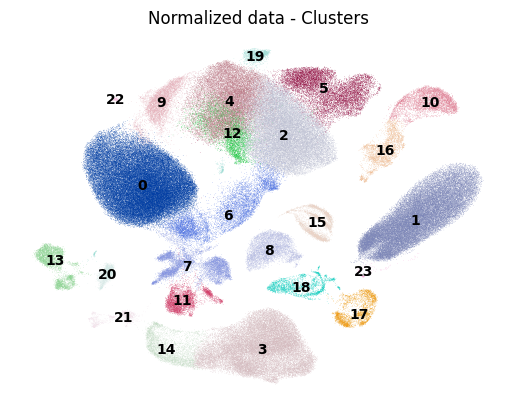

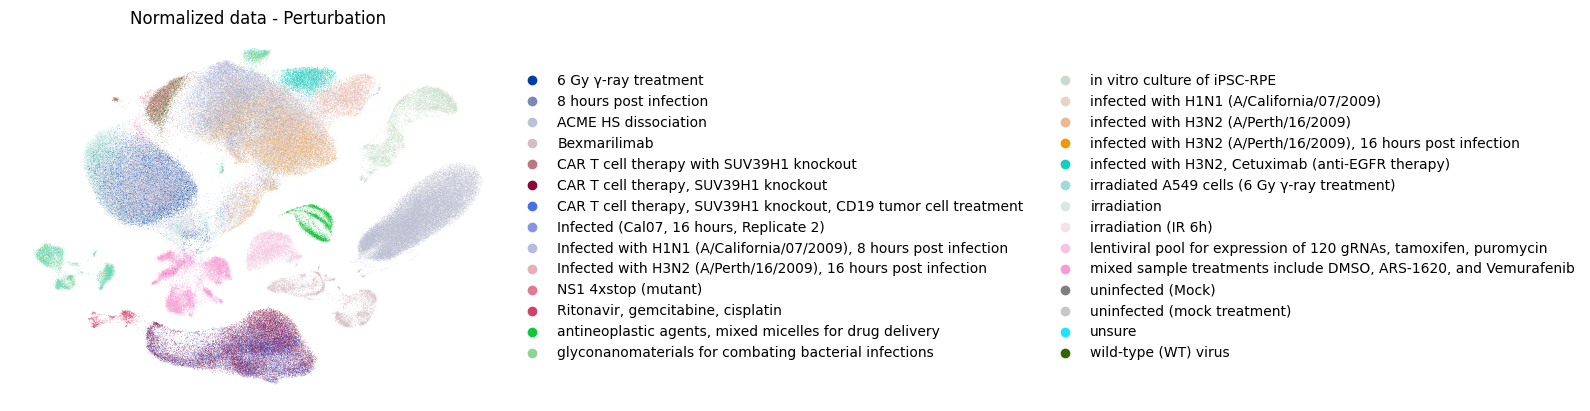

In [2]:
# Create a copy of the original data for visualization before normalization
combined_raw = combined.copy()

# Normalize and log transform
X_norm = sc.pp.normalize_total(combined, target_sum=1e4, inplace=False)["X"]
combined_norm = combined.copy()
combined_norm.X = X_norm

# Check if data is already log-transformed
if combined_norm.X.min() >= 0:  # Only log-transform if data isn't already logged
   sc.pp.log1p(combined_norm)

# Fix the highly_variable_genes call by avoiding infinity values and removing parameters causing issues
# Use flavor='seurat_v3' which is more robust to different data distributions
sc.pp.highly_variable_genes(
   combined_norm,  # Use the normalized data
   n_top_genes=2000,  # Specify number of genes instead of cutoffs
   flavor="seurat_v3",
   batch_key=None,
   span=0.3
)

# PCA and UMAP for both raw and normalized data
# For raw data (before normalization and log transformation)
sc.pp.pca(combined_raw, n_comps=30)
sc.pp.neighbors(combined_raw, n_neighbors=10, n_pcs=30)
sc.tl.umap(combined_raw)

# For normalized data (after normalization and log transformation)
sc.pp.pca(combined_norm, n_comps=30, use_highly_variable=True)
sc.pp.neighbors(combined_norm, n_neighbors=10, n_pcs=30)
sc.tl.umap(combined_norm)

# Create a figure directory
fig_dir = "a549_analysis_figures"
os.makedirs(fig_dir, exist_ok=True)
sc.settings.figdir = fig_dir  # Set the default figure directory

# Plot UMAP colored by sample for both raw and normalized data
# Raw data (before normalization and log transformation)
plt.figure(figsize=(10, 8))
sc.pl.umap(combined_raw, color='sample_id', frameon=False, 
          title='Raw data - UMAP by sample',
          save='umap_by_sample_raw.png',
          show=False)
plt.close()

# Normalized data (after normalization and log transformation)
plt.figure(figsize=(10, 8))
sc.pl.umap(combined_norm, color='sample_id', frameon=False, 
          title='Normalized data - UMAP by sample',
          save='umap_by_sample_normalized.png',
          show=False)
plt.close()

# Analysis of quality metrics across samples
# Check if 'n_genes' and 'umi_count' are available in the data
# If not, use other QC metrics if available
metrics_x = 'sample_id'
metrics_y = []

if 'n_genes' in combined_raw.obs.columns:
   metrics_y.append('n_genes')
elif 'gene_count' in combined_raw.obs.columns:
   metrics_y.append('gene_count')
   
if 'umi_count' in combined_raw.obs.columns:
   metrics_y.append('umi_count')
elif 'total_counts' in combined_raw.obs.columns:
   metrics_y.append('total_counts')

# Only create plots if we have metrics to show
if metrics_y:
   fig, axs = plt.subplots(len(metrics_y), 2, figsize=(15, 6*len(metrics_y)))
   
   for i, metric in enumerate(metrics_y):
       # Handle case with only one metric
       if len(metrics_y) == 1:
           ax_raw = axs[0]
           ax_norm = axs[1]
       else:
           ax_raw = axs[i, 0]
           ax_norm = axs[i, 1]
       
       # Raw data plot
       sns.boxplot(x=metrics_x, y=metric, data=combined_raw.obs, ax=ax_raw)  
       ax_raw.set_title(f'Raw data - {metric} by sample')
       ax_raw.set_xticklabels(ax_raw.get_xticklabels(), rotation=90)
       
       # Normalized data plot
       sns.boxplot(x=metrics_x, y=metric, data=combined_norm.obs, ax=ax_norm)
       ax_norm.set_title(f'Normalized data - {metric} by sample')
       ax_norm.set_xticklabels(ax_norm.get_xticklabels(), rotation=90)
   
   plt.tight_layout()
   plt.savefig(os.path.join(fig_dir, 'qc_metrics_comparison.png'))
   plt.close()

# Cluster the cells for both raw and normalized data
# Raw data (before normalization and log transformation)
sc.tl.leiden(combined_raw, resolution=0.5)
sc.pl.umap(combined_raw, color='leiden', legend_loc='on data', frameon=False, 
         title='Raw data - Clusters',
         save='umap_clusters_raw.png')

# Normalized data (after normalization and log transformation)
sc.tl.leiden(combined_norm, resolution=0.5)
sc.pl.umap(combined_norm, color='leiden', legend_loc='on data', frameon=False, 
         title='Normalized data - Clusters',
         save='umap_clusters_normalized.png')

# If 'drug' column exists, plot UMAP colored by drug
if 'drug' in combined_norm.obs.columns:
   sc.pl.umap(combined_norm, color='drug', frameon=False,
              title='Normalized data - Drug Treatment',
              save='umap_drug_treatments.png')

# If 'perturbation' column exists, plot UMAP colored by perturbation
if 'perturbation' in combined_norm.obs.columns:
   sc.pl.umap(combined_norm, color='perturbation', frameon=False,
              title='Normalized data - Perturbation',
              save='umap_perturbations.png')

# Save the normalized anndata object for further analysis
combined_norm.write_h5ad(os.path.join(fig_dir, 'normalized_data.h5ad'))

In [20]:
for i in combined_norm.obs['perturbation'].unique():
   print(i)

wild-type (WT) virus
irradiated A549 cells (6 Gy γ-ray treatment)
Infected (Cal07, 16 hours, Replicate 2)
CAR T cell therapy with SUV39H1 knockout
infected with H3N2 (A/Perth/16/2009)
8 hours post infection
irradiation
Ritonavir, gemcitabine, cisplatin
glyconanomaterials for combating bacterial infections
uninfected (mock treatment)
NS1 4xstop (mutant)
infected with H3N2, Cetuximab (anti-EGFR therapy)
in vitro culture of iPSC-RPE
mixed sample treatments include DMSO, ARS-1620, and Vemurafenib
6 Gy γ-ray treatment
CAR T cell therapy, SUV39H1 knockout, CD19 tumor cell treatment
unsure
antineoplastic agents, mixed micelles for drug delivery
irradiation (IR 6h)
Infected with H3N2 (A/Perth/16/2009), 16 hours post infection
uninfected (Mock)
infected with H3N2 (A/Perth/16/2009), 16 hours post infection
ACME HS dissociation
CAR T cell therapy, SUV39H1 knockout
lentiviral pool for expression of 120 gRNAs, tamoxifen, puromycin
Infected with H1N1 (A/California/07/2009), 8 hours post infection
in

In [22]:
combined_norm

AnnData object with n_obs × n_vars = 246262 × 33388
    obs: 'gene_count', 'umi_count', 'SRX_accession', 'sample_id', 'batch', 'n_genes', 'tissue', 'disease', 'perturbation', 'cell_line', 'leiden'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_id_colors', 'leiden', 'leiden_colors', 'perturbation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Identified mock groups: ['uninfected (mock treatment)', 'uninfected (Mock)']
Categories (28, object): ['6 Gy γ-ray treatment', '8 hours post infection', 'ACME HS dissociation', 'Bexmarilimab', ..., 'uninfected (Mock)', 'uninfected (mock treatment)', 'unsure', 'wild-type (WT) virus']

Comparing: wild-type (WT) virus vs mock-like controls
Group labels in subset: ['wild-type (WT) virus' 'mock']


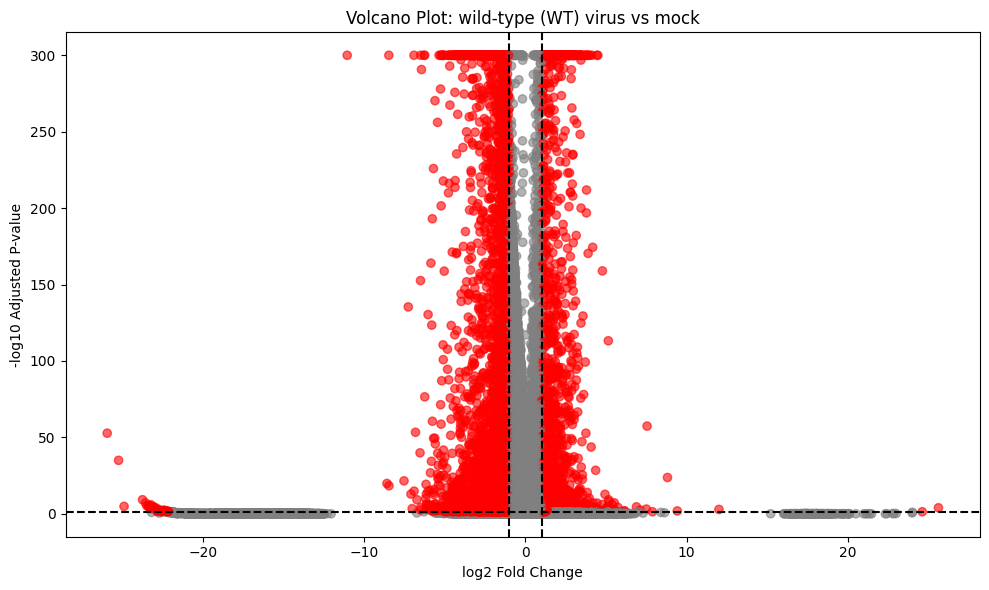


Comparing: irradiated A549 cells (6 Gy γ-ray treatment) vs mock-like controls
Group labels in subset: ['irradiated A549 cells (6 Gy γ-ray treatment)' 'mock']


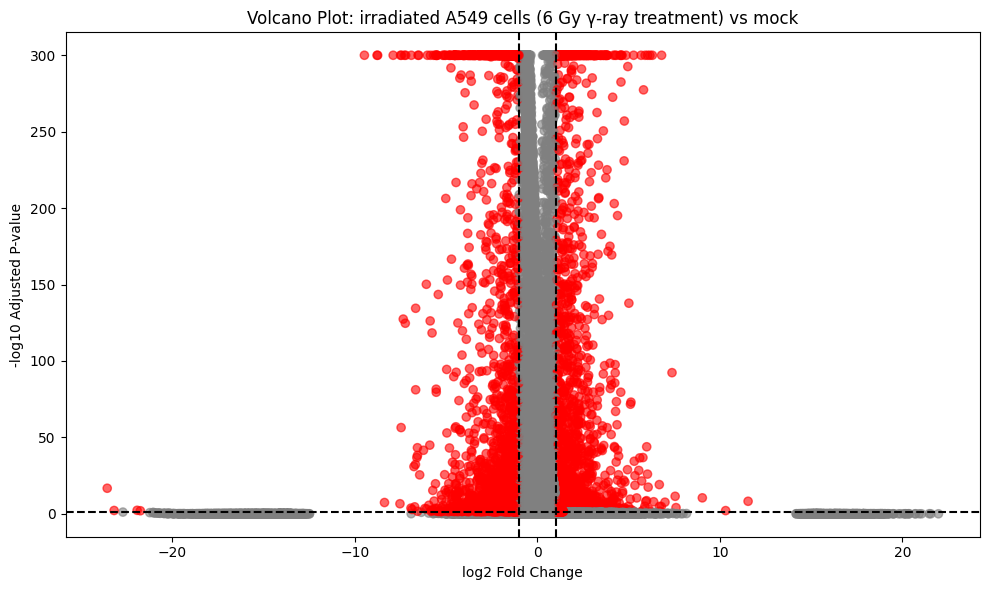


Comparing: Infected (Cal07, 16 hours, Replicate 2) vs mock-like controls
Group labels in subset: ['Infected (Cal07, 16 hours, Replicate 2)' 'mock']


KeyboardInterrupt: 

In [25]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

# Step 1: Subset to mock vs target perturbation
perturbations = combined_norm.obs['perturbation'].unique()
perturbations = [p for p in perturbations if 'mock' not in p]

# Loop through each perturbation vs mockimport scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Identify control samples (any perturbation containing 'mock' or 'Mock')
is_mock = combined_norm.obs['perturbation'].str.contains('mock', case=False, na=False)
mock_labels = combined_norm.obs['perturbation'][is_mock].unique()
print("Identified mock groups:", mock_labels)

# Identify non-mock perturbation groups
perturbations = combined_norm.obs['perturbation'].unique()
perturbations = [p for p in perturbations if not any(m.lower() in p.lower() for m in mock_labels)]

# Loop through each non-mock perturbation
for perturb in perturbations:
    print(f"\nComparing: {perturb} vs mock-like controls")

    # Subset: this perturbation + all mock-like controls
    selected_cells = combined_norm.obs['perturbation'].apply(
        lambda x: (perturb == x) or ('mock' in str(x).lower())
    )
    adata_sub = combined_norm[selected_cells].copy()

    # Group labels: control vs this perturbation
    adata_sub.obs['group'] = adata_sub.obs['perturbation'].apply(
        lambda x: 'mock' if 'mock' in str(x).lower() else str(x)
    )
    print("Group labels in subset:", adata_sub.obs['group'].unique())

    # Differential expression
    sc.tl.rank_genes_groups(
        adata_sub,
        groupby='group',
        groups=[perturb],
        reference='mock',
        method='wilcoxon',
        use_raw=False
    )

    # Extract results
    result = adata_sub.uns['rank_genes_groups']
    genes = result['names'][perturb]
    logfc = result['logfoldchanges'][perturb]
    pvals = result['pvals'][perturb]
    pvals_adj = result['pvals_adj'][perturb]

    # Make DataFrame
    df = pd.DataFrame({
        'gene': genes,
        'log2FC': logfc,
        'pval': pvals,
        'pval_adj': pvals_adj
    })
    df['-log10(pval_adj)'] = -np.log10(df['pval_adj'] + 1e-300)
    df['significant'] = (df['pval_adj'] < 0.05) & (np.abs(df['log2FC']) > 1)

    # Volcano plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df['log2FC'], df['-log10(pval_adj)'],
                c=df['significant'].map({True: 'red', False: 'grey'}), alpha=0.6)
    plt.axhline(-np.log10(0.05), linestyle='--', color='black')
    plt.axvline(1, linestyle='--', color='black')
    plt.axvline(-1, linestyle='--', color='black')
    plt.title(f'Volcano Plot: {perturb} vs mock')
    plt.xlabel('log2 Fold Change')
    plt.ylabel('-log10 Adjusted P-value')
    plt.tight_layout()
    plt.show()

for perturb in perturbations:
    print(f"Comparing: {perturb} vs mock")

    # Step 2: Subset AnnData
    adata_sub = combined_norm[combined_norm.obs['perturbation'].isin(['mock', perturb])].copy()
    adata_sub.obs['group'] = adata_sub.obs['perturbation'].astype(str)

    # Step 3: Differential expression (use Wilcoxon rank-sum)
    sc.tl.rank_genes_groups(
        adata_sub,
        groupby='group',
        groups=[perturb],
        reference='mock',
        method='wilcoxon',
        use_raw=False  # assuming data already normalized/log1p
    )

    # Step 4: Extract results
    result = adata_sub.uns['rank_genes_groups']
    genes = result['names'][perturb]
    logfc = result['logfoldchanges'][perturb]
    pvals = result['pvals'][perturb]
    pvals_adj = result['pvals_adj'][perturb]

    # Step 5: Build DataFrame
    df = pd.DataFrame({
        'gene': genes,
        'log2FC': logfc,
        'pval': pvals,
        'pval_adj': pvals_adj
    })

    # Step 6: Volcano plot
    df['-log10(pval_adj)'] = -np.log10(df['pval_adj'] + 1e-300)
    df['significant'] = (df['pval_adj'] < 0.05) & (np.abs(df['log2FC']) > 1)

    plt.figure(figsize=(10, 6))
    plt.scatter(df['log2FC'], df['-log10(pval_adj)'], 
                c=df['significant'].map({True: 'red', False: 'grey'}), 
                alpha=0.6)
    plt.axhline(-np.log10(0.05), linestyle='--', color='black')
    plt.axvline(1, linestyle='--', color='black')
    plt.axvline(-1, linestyle='--', color='black')
    plt.title(f'Volcano Plot: {perturb} vs mock')
    plt.xlabel('log2 Fold Change')
    plt.ylabel('-log10 Adjusted P-value')
    plt.tight_layout()
    
    # Save the plot
    os.makedirs('volcano_plots', exist_ok=True)
    plt.savefig(f'volcano_plots/{perturb}_vs_mock_volcano.png', dpi=300)
    plt.show()


    #########
    xlim = (-5, 5)
    ylim = (0, 50)

    # Optional: downsample non-significant points for speed/clarity
    non_sig = df[~df['significant']].sample(frac=0.1, random_state=42)
    sig = df[df['significant']]

    plt.figure(figsize=(10, 6))
    plt.scatter(non_sig['log2FC'], non_sig['-log10(pval_adj)'], c='grey', alpha=0.3, s=10)
    plt.scatter(sig['log2FC'], sig['-log10(pval_adj)'], c='red', alpha=0.6, s=12)

    plt.axhline(-np.log10(0.05), linestyle='--', color='black')
    plt.axvline(1, linestyle='--', color='black')
    plt.axvline(-1, linestyle='--', color='black')

    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.title(f'Volcano Plot: {perturb} vs mock')
    plt.xlabel('log2 Fold Change')
    plt.ylabel('-log10 Adjusted P-value')
    plt.tight_layout()
    
    # Save the zoomed plot
    os.makedirs('volcano_plots', exist_ok=True)
    plt.savefig(f'volcano_plots/{perturb}_vs_mock_volcano_zoomed.png', dpi=300)
    plt.show()
